<a href="https://colab.research.google.com/github/Amirosein/MilkywayFormation/blob/main/MilkyWay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, requests, zipfile
from zipfile import ZipFile

!pip install tsfresh
from tsfresh import extract_features

!pip install pyunpack
!pip install patool
from pyunpack import Archive

import warnings
warnings.filterwarnings('ignore')


# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 81kB 8.5MB/s 


> * **Save file function**

In [2]:
def savefile(df,name):
  t = df
  t.to_csv(name, header=True, index=True)
  return 0

# Mount drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# **Convert Dat. files to a CSV Function**


In [9]:
import pandas as pd
from pathlib import Path
import csv
from pathlib import Path

f = open("/content/draft.csv", "x")

# function
def data2csv(path, var, os):
  files = Path(path).rglob("*.dat")

  i = 0

  for file in files:
    datContent = [i.strip().split() for i in open(file).readlines()]
    id = os +'-'+ Path(file).stem
    
    # write it as a new CSV file
    with open("/content/draft.csv", "w") as f:
      writer = csv.writer(f)
      writer.writerows(datContent)

    df = pd.read_csv("/content/draft.csv", names=['time','value','e']) 
    df = df[['time','value']]
    df['id'] = id
    df['kind'] = var

    if i==0:
      data = df
    else:
      data = pd.concat([data,df], axis=0)

    i = i+1
    #print(i)

  return data

# Convert and Save data

In [ ]:
Archive('/content/drive/MyDrive/LPV.rar').extractall('/content/drive/MyDrive')


> * **LMC**

In [ ]:
LMC3_I1 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p1', 'I','III')
LMC3_I2 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p2', 'I','III')
LMC3_I3 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p3', 'I','III')
LMC3_I4 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p4', 'I','III')
LMC3_I5 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p5', 'I','III')
LMC3_I6 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p6', 'I','III')
LMC3_I7 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p7', 'I','III')
LMC3_I8 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p8', 'I','III')
LMC3_I9 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p9', 'I','III')
LMC3_I10 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p10', 'I','III')
LMC3_I11 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p11', 'I','III')
LMC3_I12 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p12', 'I','III')
LMC3_I13 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p13', 'I','III')
LMC3_I14 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p14', 'I','III')
LMC3_I15 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p15', 'I','III')
LMC3_I16 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p16', 'I','III')
LMC3_I17 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p17', 'I','III')
LMC3_I18 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/I/p18', 'I','III')

LMC3_I = pd.concat([LMC3_I1,LMC3_I2,LMC3_I3,LMC3_I4,LMC3_I5,LMC3_I6,
                    LMC3_I7,LMC3_I8,LMC3_I9,LMC3_I10,LMC3_I11,LMC3_I12,
                    LMC3_I13,LMC3_I14,LMC3_I15,LMC3_I16,LMC3_I17,LMC3_I18])


In [ ]:
LMC3_V1 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p1', 'V','III')
LMC3_V2 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p2', 'V','III')
LMC3_V3 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p3', 'V','III')
LMC3_V4 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p4', 'V','III')
LMC3_V5 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p5', 'V','III')
LMC3_V6 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p6', 'V','III')
LMC3_V7 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p7', 'V','III')
LMC3_V8 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p8', 'V','III')
LMC3_V9 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p9', 'V','III')
LMC3_V10 = data2csv('/content/drive/MyDrive/LPV/IIILMC/phot/V/p10', 'V','III')

LMC3_V = pd.concat([LMC3_V1,LMC3_V2,LMC3_V3,LMC3_V4,LMC3_V5,LMC3_V6,
                    LMC3_V7,LMC3_V8,LMC3_V9,LMC3_V10])


In [ ]:
LPV_LMC = pd.concat([LMC3_I,LMC3_V])
  
LPV_LMC['class'] = 'LPV'  
savefile(LPV_LMC,'LPV_LMC')
LPV_LMC.head()

,time,value,id,kind,class
0,2171.86025,14.956,III-OGLE-LMC-LPV-00001,I,LPV
1,2183.81956,14.961,III-OGLE-LMC-LPV-00001,I,LPV
2,2184.81907,14.961,III-OGLE-LMC-LPV-00001,I,LPV
3,2188.86966,14.970,III-OGLE-LMC-LPV-00001,I,LPV
4,2191.78070,14.955,III-OGLE-LMC-LPV-00001,I,LPV


> * **SMC**

In [ ]:
SMC3_I1 = data2csv('/content/drive/MyDrive/LPV/III/phot/I/p1', 'I','III')
SMC3_I2 = data2csv('/content/drive/MyDrive/LPV/III/phot/I/p2', 'I','III')
SMC3_I3 = data2csv('/content/drive/MyDrive/LPV/III/phot/I/p3', 'I','III')
SMC3_I4 = data2csv('/content/drive/MyDrive/LPV/III/phot/I/p4', 'I','III')
SMC3_I = pd.concat([SMC3_I1,SMC3_I2,SMC3_I3,SMC3_I4])

savefile(SMC3_I,'SMC3_I')

In [ ]:
SMC3_V1 = data2csv('/content/drive/MyDrive/LPV/III/phot/V/p1', 'V','III')
SMC3_V2 = data2csv('/content/drive/MyDrive/LPV/III/phot/V/p2', 'V','III')
SMC3_V3 = data2csv('/content/drive/MyDrive/LPV/III/phot/V/p3', 'V','III')
SMC3_V4 = data2csv('/content/drive/MyDrive/LPV/III/phot/V/p4', 'V','III')
SMC3_V = pd.concat([SMC3_V1,SMC3_V2,SMC3_V3,SMC3_V4])

savefile(SMC3_V,'SMC3_V')

In [ ]:
LPV_SMC = pd.concat([SMC3_I,SMC3_V])
  
LPV_SMC['class'] = 'LPV'  
savefile(LPV_SMC,'LPV_SMC')
LPV_SMC.head()

,time,value,id,kind,class
0,2088.91535,14.977,III-OGLE-SMC-LPV-00001,I,LPV
1,2090.87535,14.978,III-OGLE-SMC-LPV-00001,I,LPV
2,2103.92958,14.980,III-OGLE-SMC-LPV-00001,I,LPV
3,2104.94812,14.986,III-OGLE-SMC-LPV-00001,I,LPV
4,2106.84596,14.998,III-OGLE-SMC-LPV-00001,I,LPV


In [ ]:
#SMC3 = pd.concat([SMC3_I,SMC3_V])
#LMC3 = pd.concat([LMC3_I,LMC3_V])
#LMC4 = pd.concat([LMC4_I,LMC4_V])
#SMC4 = pd.concat([SMC4_I,SMC4_V])

#LPV['class'] = 'LPV' 

LPV = pd.concat([LPV_LMC,LPV_SMC])

savefile(LPV,'LPV')
LPV.head()

,time,value,id,kind,class
0,2171.86025,14.956,III-OGLE-LMC-LPV-00001,I,LPV
1,2183.81956,14.961,III-OGLE-LMC-LPV-00001,I,LPV
2,2184.81907,14.961,III-OGLE-LMC-LPV-00001,I,LPV
3,2188.86966,14.970,III-OGLE-LMC-LPV-00001,I,LPV
4,2191.78070,14.955,III-OGLE-LMC-LPV-00001,I,LPV


In [ ]:
zipObj = ZipFile('LPV.zip', 'w', zipfile.ZIP_BZIP2)

zipObj.write('/content/LPV')
zipObj.close()

# **Feature Selection :**

In [5]:
Archive('/content/drive/MyDrive/Feature Selection Sample dataset.rar').extractall('/content')

In [10]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters, ComprehensiveFCParameters

def ftrs(X,cls):
  m = extract_features(X, column_id="id", column_sort="time", n_jobs= 5,
                       column_kind="kind", column_value="value",
                       default_fc_parameters = ComprehensiveFCParameters())
  m['class'] = cls
  return m

In [11]:
def dat2feat(urlI,urlV,cls):
  mI = data2csv(urlI, 'I','S')
  mV = data2csv(urlV, 'V','S')
  m = pd.concat([mI,mV])
  
  f = ftrs(m,cls)

  return f

> * Creating Sample Dataset for Feature Selection

In [13]:
ur11 = '/content/Anomalous-Cepheids/I'
ur12 = '/content/Anomalous-Cepheids/V'
ur21 = '/content/classical-Cepheids/I'
ur22 = '/content/classical-Cepheids/V'
ur31 = '/content/Double-Period-Variables/I'
ur32 = '/content/Double-Period-Variables/V'
ur41 = '/content/Eclipsing-and-ellipsoidal-binary-sys/I'
ur42 = '/content/Eclipsing-and-ellipsoidal-binary-sys/V'
ur51 = '/content/Long-period-variables/I'
ur52 = '/content/Long-period-variables/V'
ur61 = '/content/R-CrB/I'
ur62 = '/content/R-CrB/V'
ur71 = '/content/RR-Lyrae/I'
ur72 = '/content/RR-Lyrae/V'
ur81 = '/content/Type-II-Cepheids/I'
ur82 = '/content/Type-II-Cepheids/V'
ur91 = '/content/δ-Scuti/I'
ur92 = '/content/δ-Scuti/V'


ACEP_sf = dat2feat(ur11,ur12,'ACEP')
CEP_sf = dat2feat(ur21,ur22,'CEP')
DPV_sf = dat2feat(ur31,ur32,'DPV')
ECL_sf = dat2feat(ur41,ur42,'ECL')
LPV_sf = dat2feat(ur51,ur52,'LPV')
RCB_sf = dat2feat(ur61,ur62,'RCB')
RRLYR_sf = dat2feat(ur71,ur72,'RRLYR')
T2CEP_sf = dat2feat(ur81,ur82,'T2CEP')
DSCT_sf = dat2feat(ur91,ur92,'DSCT')

data = pd.concat([ACEP_sf, CEP_sf, DPV_sf, ECL_sf, LPV_sf,
                  RCB_sf, RRLYR_sf, T2CEP_sf, DSCT_sf])

Feature Extraction: 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


In [160]:
X = data.iloc[:,0:1574]
Y = data.loc[:,'class']

In [157]:
# Output Encoding
from sklearn.preprocessing import OneHotEncoder

a = np.array(Y)
OH_Enc = OneHotEncoder( )
OH_Encoded = OH_Enc.fit_transform(a.reshape(-1,1)).toarray()
OH_Y = pd.DataFrame(OH_Encoded)
OH_Y.columns = ['OH1','OH2','OH3','OH4','OH5','OH6','OH7','OH8','OH9']

from sklearn import preprocessing

LE = preprocessing.LabelEncoder()
y = LE.fit_transform(Y)

O_Y = pd.DataFrame(y)
O_Y.columns = ['OY']

In [162]:
# Input Imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

nc = X.columns[X.isnull().all()].tolist()
X.drop(nc, inplace=True, axis=1)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = IterativeImputer(n_nearest_features=30)
imp_data = imp.fit_transform(X)
X = pd.DataFrame(imp_data, columns= X.columns)


> * **Relevant Features :**

In [235]:
import tsfresh

y = O_Y
y = y.squeeze()

# which are now filtered to only contain relevant features
X_tsfresh_filtered = tsfresh.feature_selection.select_features(X, y, multiclass=True, n_significant=9,
                                                               n_jobs=4, ml_task='classification')

# construct the corresponding settings object
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_tsfresh_filtered)

X_tsfresh_filtered.shape

(1429, 62)

Text(0.5, 0, 'Significant_Class')

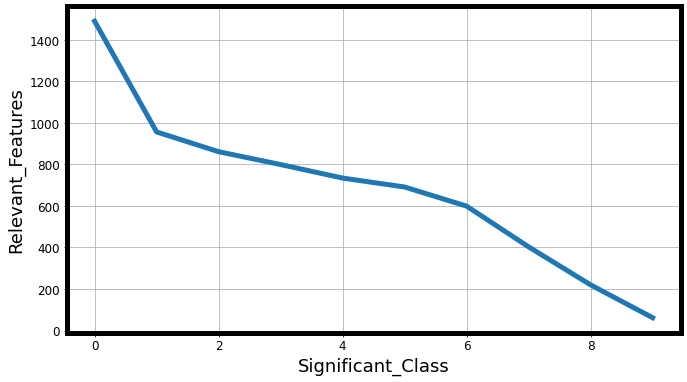

In [234]:
a = np.arange(0,10)
b = np.array([1489, 956, 861, 799, 734, 691, 599, 403, 220, 62])

plt.figure(figsize=(11,6))
plt.grid()
plt.plot(a,b)

plt.ylabel('Relevant_Features')
plt.xlabel('Significant_Class')

# Feature Extraction Function

In [236]:
def feat_ex(X,cls):
  m = extract_features(X, column_id="id", column_sort="time", n_jobs= 20,
                       column_kind="kind", column_value="value",
                       kind_to_fc_parameters = kind_to_fc_parameters)
  m['class'] = cls
  return m

In [200]:
Archive('/content/drive/MyDrive/CEP.rar').extractall('/content')
CEP = pd.read_csv('/content/CEP', index_col=0, header=0)

CEP.head()

,time,value,id,kind,class
0,2184.81184,17.946,III-OGLE-LMC-CEP-0001,I,CEP
1,2188.86239,17.631,III-OGLE-LMC-CEP-0001,I,CEP
2,2191.77255,17.858,III-OGLE-LMC-CEP-0001,I,CEP
3,2200.79366,17.759,III-OGLE-LMC-CEP-0001,I,CEP
4,2206.72879,17.686,III-OGLE-LMC-CEP-0001,I,CEP


In [1]:
#Extracting features

CEP_f = feat_ex(CEP,'CEP')  
savefile(CEP_f,'CEP_f')

CEP_f.head()

In [241]:
import pickle

a_file = open("data.pkl", "wb")
pickle.dump(kind_to_fc_parameters, a_file)
a_file.close()

#a_file = open("data.pkl", "rb")
#output = pickle.load(a_file)
#print(output)
#a_file.close()

# Outputs Encoding

> * **One-Hot Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

a = np.array(data['class'])
OH_Enc = OneHotEncoder( )
OH_Encoded = OH_Enc.fit_transform(a.reshape(-1,1)).toarray()
OH_Outputs = pd.DataFrame(OH_Encoded)
OH_Outputs.columns = ['OH1','OH2','OH3','OH4','OH5']

data = pd.concat([data,OH_Outputs], axis=1)
data.head()

#a = OH_Enc.inverse_transform(np.array([[1, 0, 0, 0, 0],[0, 1, 0, 0, 0],[0, 0, 1, 0, 0]
             #             ,[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]]))

#print('[1, 0, 0, 0, 0] =',a[0],'\n')
#print('[0, 1, 0, 0, 0] =',a[1],'\n')
#print('[0, 0, 1, 0, 0] =',a[2],'\n')
#print('[0, 0, 0, 1, 0] =',a[3],'\n')
#print('[0, 0, 0, 0, 1] =',a[4],'\n')

> * **Ordinal Encoding**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['class'])
Ordinal_Y = le.transform(data['class']) 
Y_O = pd.DataFrame(Ordinal_Y)
Y_O.columns = ['Y']

data = pd.concat([data,Y_O], axis=1)
data.head()

#le.inverse_transform([0, 1, 2, 3, 4])

# Shuffle and Imputation

> * Shuffle

In [ ]:
from sklearn.utils import shuffle

data = shuffle(data, random_state=42)
data = data.reset_index()

X = data.loc[:,'Jmag (1.22u)':'160u flux']
Y = data.loc[:,'y1':'y5']
categories = data['class']

data.head()

> * Iterative Imputer

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer()
imp_data = imp.fit_transform(X)
X = pd.DataFrame(imp_data, columns= X.columns)